# Project 7

Please remember to download your completed notebook, both as
`.ipynb` and `.html`.

A hospital in Philadelphia is trying to better streamline its operations and plan for the future by reducing the number hospitalizations that could have been prevented. They have approached you, a data scientist, to help predict if patients will develop heart diseases so that healthcare providers have a chance to intervene much earlier. For this task, you have been provided with the Heart dataset, containing a binary outcome 'HD' that indicates the presence of heart disease in 303 patients. There are 13 predictors including 'Age', 'Sex', 'Chol' (a cholesterol measurement), and other heart and lung function measurements.

In this assignment, we will be using PennGrader, a Python package built by a former TA for autograding Python notebooks. PennGrader was developed to provide students with instant feedback on their answer. You can submit your answer and know whether it's right or wrong instantly. We then record your most recent answer in our backend database. You will have 100 attempts per test case, which should be more than sufficient.  

<b>NOTE：Please remember to remove the </b>

```python
raise notImplementedError
```
<b>after your implementation, otherwise the cell will not compile.</b>

## Getting Set Up
Meet our old friend - PennGrader! Fill in the cell below with your PennID and then run the following cell to initialize the grader.

<font color='red'>Warning:</font> Please make sure you only have one copy of the student notebook in your directory in Codio upon submission. The autograder looks for the variable `STUDENT_ID` across all notebooks, so if there is a duplicate notebook, it will fail.

In [2]:
#PLEASE ENSURE YOUR STUDENT_ID IS ENTERED AS AN INT (NOT A STRING). IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND

STUDENT_ID = 57896467                  # YOUR 8-DIGIT PENNID GOES HERE
STUDENT_NAME = "Emmanuel Murerwa"     # YOUR FULL NAME GOES HERE

In [3]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'ESE305_FA_2021_HW7', student_id = STUDENT_ID)

In [4]:
# Let's import the relevant Python packages here
# Feel free to import any other packages for this project

import pandas as pd
import numpy as np

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Preprocessing Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer #One hot encoding
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 
import pydotplus

#Bootstrap
from sklearn.utils import resample

#Models
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn import ensemble
%matplotlib inline

Now we are ready for this project. Before building our models, let's take a look at how the data looks like.
1. Load the Heart data and drop any rows with `NaN/null` values.

In [5]:
heart = pd.read_csv('Heart.csv')

# Drop all rows with NaN/null inplace
heart = heart.dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,HD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [6]:
grader.grade(test_case_id = 'test_read_data', answer = heart.shape)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


2. Binarize the 'HD' values such that `No=0` and `Yes=1`. One hot encode categorical features, and set prefixes to original column names. Produce some numerical and graphical summaries of it. Do there appear to be any patterns? 

Hint: Don't forget to drop original columns after one hot encode.

The order of your columns should be as follows:  

* Age	
* Sex	
* RestBP	
* Chol	
* Fbs
* RestECG
* MaxHR
* ExAng
* Oldpeak
* Slope
* Ca
* HD
* ChestPain_asymptomatic
* ChestPain_nonanginal
* ChestPain_nontypical
* ChestPain_typical
* Thal_fixed
* Thal_normal
* Thal_reversable

In [7]:
# Enter your code here, all changes should be made inplace
encode = lambda x: 1 if x == 'Yes' else 0
heart['HD'] = heart['HD'].map(encode)
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,HD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


In [8]:
dummies = pd.get_dummies(heart[['ChestPain', 'Thal']]) #One Hot encoding
#y = heart.HD
# Drop the column with categorical variables
X_ = heart.drop(['ChestPain', 'Thal'], axis=1).astype('float64')
heart = pd.concat([X_, dummies[['ChestPain_asymptomatic', 'ChestPain_nonanginal', 'ChestPain_nontypical', 'ChestPain_typical', 'Thal_fixed', 'Thal_normal', 'Thal_reversable']]], axis=1)
heart.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,HD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,0.0,0,0,0,1,1,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,1.0,1,0,0,0,0,1,0
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,1.0,1,0,0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,0.0,0,1,0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,0.0,0,0,1,0,0,1,0


In [9]:
grader.grade(test_case_id = 'test_hot_encode', answer = heart)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


3. What is the minimum and maximum ages of the patients in the dataset? Assign this value to the variable `min_age` and `max_age`.

In [10]:
min_age = heart['Age'].min()
max_age = heart['Age'].max()

In [11]:
grader.grade(test_case_id = 'test_age', answer = (min_age, max_age))

Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


4. Calculate the pairwise correlations between all the variables. Which predictor has the highest positive correlation with the response variable? Assign this to `highest_corr`. 

Hint: Your answer should be in the format `ColumnName_type` where the type is the result of one-hot encoding. 

In [12]:
highest_corr = "ChestPain_asymptomatic"
# Enter your code here
heart.corr()


,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,HD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
Age,1.000000,-0.092399,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.227075,0.137297,-0.043181,-0.163227,0.042571,0.059732,-0.130333,0.103792
Sex,-0.092399,1.000000,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.278467,0.085014,-0.115054,-0.041925,0.092497,0.145368,-0.390730,0.327671
RestBP,0.290476,-0.066340,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.153490,0.029082,-0.054825,-0.080820,0.149921,0.075211,-0.143474,0.109624
Chol,0.202644,-0.198089,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.080285,0.064831,-0.023570,-0.017678,-0.057040,-0.099575,0.001379,0.047368
Fbs,0.132062,0.038850,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.003167,-0.087329,0.106259,-0.053990,0.059785,0.096002,-0.072045,0.026522
RestECG,0.149917,0.033897,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.166343,0.118613,-0.088542,-0.098958,0.064395,0.043483,-0.023504,0.002695
MaxHR,-0.394563,-0.060496,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.423817,-0.377920,0.160943,0.256120,0.080420,-0.160679,0.286684,-0.213956
ExAng,0.096489,0.143581,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.421355,0.454514,-0.257718,-0.232185,-0.094329,0.063827,-0.325755,0.301283
Oldpeak,0.197123,0.106567,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.424052,0.271036,-0.117376,-0.283033,0.083559,0.101819,-0.347874,0.305253
Slope,0.159405,0.033345,0.121172,-0.009215,0.047819,0.135141,-0.389307,0.250572,0.579037,1.000000,0.109761,0.333049,0.201156,-0.085393,-0.213606,0.064052,0.186386,-0.294494,0.209335


In [13]:
grader.grade(test_case_id = 'test_corr', answer = highest_corr)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


6. Since we are interested in building a predictive model, it is good practice to split the data into training and testing sets. Using `sklearn.model_selection.train_test_split`, divide the data into these sets using a 80/20 split with a `random_state=42`. These training and testing sets will be used for all the following parts.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(heart.drop(['HD'], axis=1).astype('float64'),heart['HD'] , test_size=0.2, random_state=42)
#X_test = sm.add_constant(X_test)


In [15]:
grader.grade(test_case_id = 'test_split', answer = (X_train, y_train))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 7. Part A: Decision Tree

1. Using all predictor variables, train a <u>base</u> classification tree to predict the response variable. Use `sklearn.tree.DecisionTreeClassifier` and set `random_state=42`. 

*Hint*: here is the link for the documentation of [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [16]:
classifier = DecisionTreeClassifier(random_state=42)
clf = classifier.fit(X_train, y_train)

In [17]:
grader.grade(test_case_id = 'test_dt', answer = (clf.n_classes_, clf.n_features_))

Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


2. Plot the decision tree using the `Graphviz` package. Do you notice anything interesting?

*Hint*: To do this, click on the little computer button on the Codio sidebar that says "Open Terminal." Once you are in the terminal, copy and paste the following and hit enter:

```
pip install --upgrade pip --user
pip install pydotplus --user
pip install graphviz --user
pip install ipython --user
sudo apt-get install graphviz
```

After, save your work and then click kernel -> 'restart and run all'. You should be able to use `Graphviz` package now!

If any of the above commands fails, please replace 'pip install' with 'sudo apt-get install `<package-name>`'. If you are having trouble with the installation, please post on Piazza or visit office hours.
    
To pass the test, your img should be of type `<class 'IPython.core.display.Image'>`.

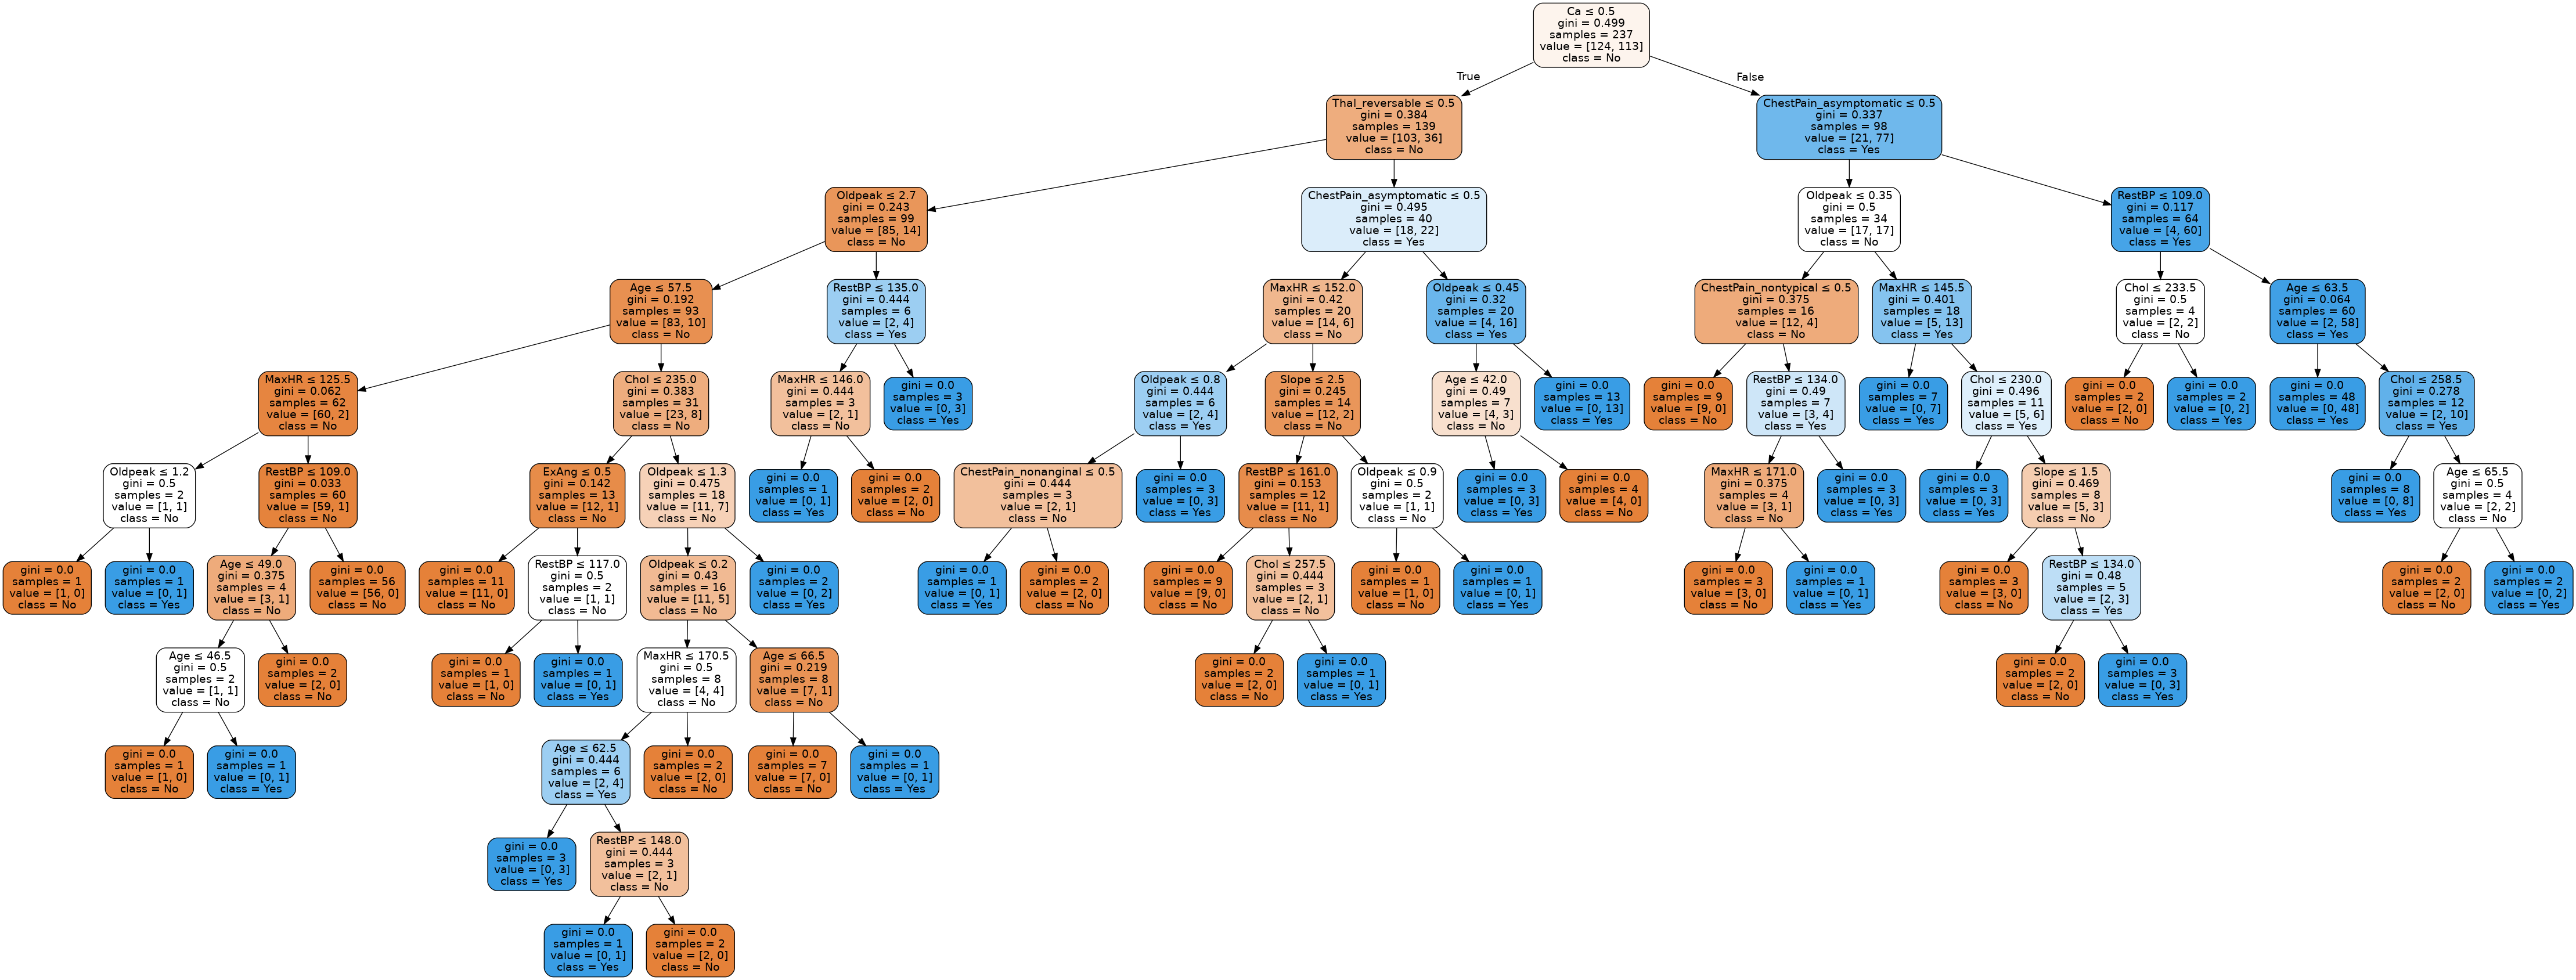

In [18]:
# You need to download this notebook to your local PC to complete this question
continuous = heart.drop(['HD'], axis=1).astype('float64')
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=continuous.columns, #names of the features being used
                         class_names=['No','Yes'], #for categorical variables only 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)

img = Image(graph.create_png())
img

In [19]:
grader.grade(test_case_id = 'test_image', answer = (str(type(img))))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


3. Evaluate your base model on the test set by calculating the precision, recall and accuracy. Assign these values to `dt_precision`, `dt_recall` and `dt_accuracy` respectively. Name your model `dt`.

*Hint*: A useful resource if you need a refresher of these terms is [here](https://en.wikipedia.org/wiki/Precision_and_recall).

In [20]:
p = classifier.predict(X_test)
print(confusion_matrix(p, y_test))
print(classification_report(y_test, p,))
dt_precision = 0.72
dt_recall = 0.88
dt_accuracy = 0.81


[[28  3]
 [ 8 21]]
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84        36
         1.0       0.72      0.88      0.79        24

    accuracy                           0.82        60
   macro avg       0.81      0.83      0.81        60
weighted avg       0.83      0.82      0.82        60



In [21]:
grader.grade(test_case_id = 'test_dt_score', answer = (dt_precision, dt_recall, dt_accuracy))

Correct! You earned 1.5/1.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


4a. Which hyperparameter should we tune when building a decision tree? Select all that applies:

A. Tree depth

B. Number of estimators

C. Number of output classes

D. Percent of samples trained

In [22]:
answers = ['A']

In [23]:
grader.grade(test_case_id = 'test_dt_tune', answer = answers)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


4b. Tune the hyperparameter you selected in the above question and evaluate this tuned model by calculating the precision, recall and accuracy on the test set. Assign these calculated values to `dt_tuned_precision`, `dt_tuned_recall` and `dt_tuned_accuracy` respectively. 

*Hint*: 
1. Refer to the documentation to determine what can be tuned. 
2. For each tuned parameter, search through range between 3 and 20 to find the best performing parameters. 
3. To tune hyperparameters, use GridSearchCV with `cv=10`. This will apply KFold on your training set so you split your training set into a smaller training set and a "validation" set, which GridSearchCV will use to pick the best parameters. If you do not specify `cv=10`, GridSearchCV will by default use 5-fold cross validation. Read more about train/validation/test sets [here](https://blog.roboflow.com/train-test-split/). 

In [24]:
# Enter your code here
classification_error_rate_scorer = make_scorer(accuracy_score)
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parameters, n_jobs=4, cv=10,
                  scoring=classification_error_rate_scorer)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_params_)

clf1 = tree.DecisionTreeClassifier(max_depth = 4,random_state = 42)
clf1.fit(X=X_train, y=y_train)
d = clf1.predict(X_test)
print(confusion_matrix(d, y_test))
print(classification_report(y_test, d,))

dt_tuned_precision = 0.67
dt_tuned_recall = 0.83
dt_tuned_accuracy = 0.77

{'max_depth': 4}
[[26  4]
 [10 20]]
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79        36
         1.0       0.67      0.83      0.74        24

    accuracy                           0.77        60
   macro avg       0.77      0.78      0.76        60
weighted avg       0.79      0.77      0.77        60



In [25]:
grader.grade(test_case_id = 'test_dt_tuned', answer = (dt_tuned_precision, dt_tuned_recall, dt_tuned_accuracy))

Correct! You earned 1.5/1.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 8. Part B: Bagging

1. Using all predictor variables, train a base model to predict the response variable. Use `sklearn.ensemble.BaggingClassifier` and set `random_state=42`. Name your model as `bag`.

In [26]:
# Enter your code here
classifier1 = BaggingClassifier(random_state=42)
bag = classifier1.fit(X_train, y_train)

In [27]:
grader.grade(test_case_id = 'test_bag', answer = bag.estimators_samples_)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


2. Evaluate your base model on the test set by calculating the precision, recall and accuracy. Assign these values to `bag_precision`, `bag_recall`  and `bag_accuracy` respectively. 

In [28]:
# Enter your code here
p = classifier1.predict(X_test)
print(confusion_matrix(p, y_test))
print(classification_report(y_test, p,))
bag_precision = 0.86
bag_recall = 0.79
bag_accuracy = 0.87

[[33  5]
 [ 3 19]]
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89        36
         1.0       0.86      0.79      0.83        24

    accuracy                           0.87        60
   macro avg       0.87      0.85      0.86        60
weighted avg       0.87      0.87      0.87        60



In [29]:
grader.grade(test_case_id = 'test_bag_score', answer = (bag_precision, bag_recall, bag_accuracy))

Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


3. Do <b>not</b> modify `base_classifier`. Tune the `n_estimators` hyperparameter of your model and evaluate this tuned model by calculating the precision, recall, and accuracy on the test set. Assign these calculated values to `bag_tuned_precision`, `bag_tuned_recall` and `bag_tuned_accuracy`  respectively. Store your best performing estimators to `bag_best_param` as a dictionary ('tuned estimator' : number). *Hint*: Set the searching space to all integers between range 5 and 29. To tune hyperparameters, use GridSearchCV with `cv=10`. This will apply KFold on your training set so you split your training set into a smaller training set and a "validation" set, which GridSearchCV will use to pick the best parameters. If you do not specify `cv=10`, GridSearchCV will by default use 5-fold cross validation. Read more about train/validation/test sets [here](https://blog.roboflow.com/train-test-split/). 

In [32]:
parameters = {'n_estimators':range(5,29)}

bag = GridSearchCV(ensemble.BaggingClassifier(random_state=42), parameters, n_jobs=4, cv=10,
                  scoring='accuracy',error_score=0)
bag.fit(X=X_train, y=y_train)
tree_model = bag.best_estimator_
print (bag.best_params_)

bag1 = ensemble.BaggingClassifier(n_estimators = 19,random_state = 42)
bag1.fit(X=X_train, y=y_train)
d = bag1.predict(X_test)
print(confusion_matrix(d, y_test))
print(classification_report(y_test, d,))


bag_tuned_precision = 0.83
bag_tuned_recall = 0.83
bag_tuned_accuracy = 0.86

bag_best_param = bag.best_params_

{'n_estimators': 19}
[[32  4]
 [ 4 20]]
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        36
         1.0       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



In [33]:
grader.grade(test_case_id = 'test_bag_tuned', answer = (bag_tuned_precision, bag_tuned_recall, bag_tuned_accuracy))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [34]:
grader.grade(test_case_id = 'test_bag_best', answer = bag_best_param)

Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 9. Part C: Random Forest

1. Using all predictor variables, train a base random forest to predict the response variable. Use `sklearn.ensemble.RandomForestClassifier` and set `random_state=42`. Name your model `rf`.

In [35]:
classifier2 = RandomForestClassifier(random_state=42)
rf = classifier2.fit(X_train, y_train)

In [36]:
grader.grade(test_case_id = 'test_rf', answer = rf.n_estimators)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


2. Evaluate your base model on the test set by calculating the precision, recall and accuracy. Assign these values to `rf_precision`, `rf_recall` and `rf_accuracy` respectively.

In [37]:
# Enter your code here
p = classifier2.predict(X_test)
print(confusion_matrix(p, y_test))
print(classification_report(y_test, p,))
rf_precision = 0.84
rf_recall = 0.88
rf_accuracy = 0.88


[[32  3]
 [ 4 21]]
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90        36
         1.0       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [38]:
grader.grade(test_case_id = 'test_rf_score', answer = (rf_precision, rf_recall, rf_accuracy))

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


3. Tune the hyperparameters of your model and evaluate this tuned model by calculating the precision, recall and accuracy on the test set. Assign these calculated values to `rf_tuned_precision`, `rf_tuned_recall` and `rf_tuned_accuracy` respectively. Store your best-performing parameters to `rf_tuned`. Also don't forget to set `random_state=42`. 

*Hint*: 
1. In this question, we would like to tune only the parameters determining the depth of a tree and the number of trees. But beware that you can also adjust the maximum number of features considered for each tree(max_features), the minimum number of data points placed in a node before the node is split(min_samples_split), the minimum number of data points allowed in a leaf node(min_samples_leaf), and bootstrap option. Refer to [sklearn.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for a complete list.
2. In this question, your parameter search space is (3,20) for tree depth, (10,29) for number of trees.
3. To tune hyperparameters, use GridSearchCV with `cv=10`. This will apply KFold on your training set so you split your training set into a smaller training set and a "validation" set, which GridSearchCV will use to pick the best parameters. If you do not specify `cv=10`, GridSearchCV will by default use 5-fold cross validation. Read more about train/validation/test sets [here](https://blog.roboflow.com/train-test-split/). 

In [40]:
parameters = {'max_depth':range(3,20), 'n_estimators':range(10,29) }

rf = GridSearchCV(ensemble.RandomForestClassifier(random_state=42), parameters, n_jobs=4, cv=10,
                  scoring='accuracy',error_score=0)
rf.fit(X=X_train, y=y_train)
tree_model = rf.best_estimator_
print (rf.best_score_, rf.best_params_)

rf1 = ensemble.RandomForestClassifier(random_state = 42)
rf1.fit(X=X_train, y=y_train)
d = rf1.predict(X_test)
print(confusion_matrix(d, y_test))
print(classification_report(y_test, d,))

# Enter your code here
rf_tuned_precision = 0.84
rf_tuned_recall = 0.88
rf_tuned_accuracy = 0.88

rf_tuned = rf.best_params_

0.818659420289855 {'max_depth': 4, 'n_estimators': 20}
[[32  3]
 [ 4 21]]
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90        36
         1.0       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [41]:
grader.grade(test_case_id = 'test_rf_tuned', answer = (rf_tuned_precision, rf_tuned_recall, rf_tuned_accuracy))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [42]:
grader.grade(test_case_id = 'test_rf_tuned_params', answer = rf_tuned)

Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


10. Of the 3 base models that you trained, which model achieved the highest test accuracy? 

A. Decision Tree

B. Bagging

C. Random Forest

In [43]:
choice = ['C']

In [44]:
grader.grade(test_case_id = 'test_base', answer = choice)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


11. Of the 3 models in which you tuned the parameters, which model achieved the highest test accuracy? 

A. Decision Tree

B. Bagging

C. Random Forest

In [47]:
choice = ['C']

In [48]:
grader.grade(test_case_id = 'test_tuned', answer = choice)

Correct! You earned 0.5/0.5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


12. *Food for thought (ungraded but interesting to think about)*: In this project, we asked you to pick the model with the highest test accuracy. For this task, do you think that accuracy is the best metric to use, or would precision, recall or even the F1-score be better?

In [49]:
#Accuracy is the best metric to use.